<a href="https://colab.research.google.com/github/bheinri2/DL_Speech_Recognition/blob/main/Preprocessing_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import librosa #, librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

In [19]:
!pip install opendatasets

In [3]:
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/jbuchner/synthetic-speech-commands-dataset")

Skipping, found downloaded files in "./synthetic-speech-commands-dataset" (use force=True to force download)


In [5]:
od.download("https://www.kaggle.com/joserzapata/free-spoken-digit-dataset-fsdd")

Skipping, found downloaded files in "./free-spoken-digit-dataset-fsdd" (use force=True to force download)


In [6]:
FILE_DIR_1 = "/content/free-spoken-digit-dataset-fsdd/recordings"
FILE_DIR_2 = "/content/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset"


#### dataset 1: spoken digits

In [7]:
# Load spoken digits audio files into padded numpy arrays and store in a list
# Takes 1 min 13 sec
max_length = 0
#audio_signals_1 = []
for root, dirs, files in os.walk(FILE_DIR_1):
  for ffile in files:
    #print(ffile)
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    max_length = max(audio_time_series.size, max_length)
    
audio_signals_1 = []
labels_1 = []
for root, dirs, files in os.walk(FILE_DIR_1):
  for ffile in files:
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    padding = max_length - audio_time_series.size
    padded = np.pad(audio_time_series, (0, padding), 'constant', 
                    constant_values=(0, 0))
    #print(padded)
    #print(padded.size)
    audio_signals_1.append(padded)
    y_num = int(str(ffile)[0])
    labels_1.append(y_num)
    #print(sr)

In [8]:
test = np.array(labels_1)
test.shape

(3000,)

In [9]:
import IPython.display as ipd
n = 503
print(labels_1[n])
#y, sr = librosa.load(audio_signals_1[n])
ipd.Audio(audio_signals_1[n],rate=sr)

4


#### dataset 2: spoken words

In [10]:
from random import sample

In [11]:
f_names = [] # list of file names of samples to take
for root, dirs, files in os.walk(FILE_DIR_2):
  for f in files:
    file_path = os.path.join(root, f)
    f_names.append(file_path)

In [12]:
f_names = np.array(f_names)
f_names.shape

(41849,)

In [13]:
max_length = 0
audio_signals_2 = []
labels_2 = []
for i in range(0, len(f_names), 5):
  f = f_names[i]
  audio_time_series, sr = librosa.load(f)
  labels_2.append(f.split('/')[5]) # appends the name of the lowest level directory for each file (which is each files corresponding label)
  audio_signals_2.append(audio_time_series)
  max_length = max(audio_time_series.size, max_length)

In [14]:
test2 = np.array(labels_2)
test2.shape

(8370,)

###### extra stuff

In [15]:

# This didn't finish after 20 mins
max_length = 0
audio_signals_2 = []
labels_2 = []
#classes = []
for root, dirs, files in os.walk(FILE_DIR_2):
  #for dir in dirs:
  #  classes.append(str(dir))
  for ffile in files:
    file_path = os.path.join(root, ffile)
    #print(file_path.split('/')[5])
    labels_2.append(file_path.split('/')[5]) # appends the name of the lowest level directory for each file (which is each files corresponding label)
    audio_time_series, sr = librosa.load(file_path)
    audio_signals_2.append(audio_time_series)
    max_length = max(audio_time_series.size, max_length)

# padding each audio signal
for signal in audio_signals_2:
  padding = max_length - signal.size
  padded_signal = np.pad(signal, (0,padding), 'constant', 
                         constant_values=(0,0))

KeyboardInterrupt: ignored

In [ ]:
# This didn't finish after 20 mins
max_length = 0
audio_signals_2 = []
labels_2 = []
#classes = []
for root, dirs, files in os.walk(FILE_DIR_2):
  #for dir in dirs:
  #  classes.append(str(dir))
  for ffile in files:
    file_path = os.path.join(root, ffile)
    #print(file_path.split('/')[5])
    labels_2.append(file_path.split('/')[5]) # appends the name of the lowest level directory for each file (which is each files corresponding label)
    audio_time_series, sr = librosa.load(file_path)
    audio_signals_2.append(audio_time_series)
    max_length = max(audio_time_series.size, max_length)

# padding each audio signal
for signal in audio_signals_2:
  padding = max_length - signal.size
  padded_signal = np.pad(signal, (0,padding), 'constant', 
                         constant_values=(0,0))
'''    
audio_signals_1 = []
for root, dirs, files in os.walk(FILE_DIR_2):
  for ffile in files:
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    padding = max_length - audio_time_series.size
    padded = np.pad(audio_time_series, (0, padding), 'constant', 
                    constant_values=(0, 0))
    #print(padded)
    #print(padded.size)
    audio_signals_1.append(padded)
    #print(sr)
'''

### Converting samples to mel-spectrograms ###

#### Helper Functions ####

In [16]:
# handles individual signal conversion
def signal_to_mel_spectrogram(signal, hop_length, n_fft):
  ''' converts a given audio signal to a mel spectrogram
  parameters: 
    signal: self-explanatory
    hop_length: number of samples to shift between transformations
    n_fft: number of samples taken per fast fourier transformations
  '''
  # Short-time Fourier Transformation on our audio data
  audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
  # gathering the absolute values for all values in our audio_stft 
  spectrogram = np.abs(audio_stft)
  # Converting the amplitude to decibels
  return librosa.amplitude_to_db(spectrogram)

In [17]:
# plots converted spectrograms (NOTE: for testing purposes)
def plot_spectro(spectrogram, sample_rate, hop_length):
  # Plotting the short-time Fourier Transformation
  plt.figure(figsize=(20, 5))
  # Using librosa.display.specshow() to create our spectrogram
  librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='hz', hop_length=hop_length, cmap='magma')
  plt.colorbar(label='Decibels')
  plt.title('Spectrogram (dB)', fontdict=dict(size=18))
  plt.xlabel('Time', fontdict=dict(size=15))
  plt.ylabel('Frequency', fontdict=dict(size=15))
  plt.show()

### More Helper functions

In [18]:
def split_data(X, Y, t_ratio=0.3):
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:t_split],       Y[0:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_test, Y_test

### Free-spoken Digit dataset conversion: ### 

In [19]:
#### BATCH CONVERSION for first (faster) set ####
### TODO: figure out best values for n_fft, hop_length
n_fft = 2048 # number of samples in a window per fft
hop_length = 512 # amount of samples we are shifting after each fft
mel_spectrograms_1 = [] # list to store each converted signal

### actual conversion process
for signal in audio_signals_1:
  ms = signal_to_mel_spectrogram(signal, hop_length, n_fft)
  mel_spectrograms_1.append(ms)

In [20]:
### Final X,Y data:
# X = mel_spectrograms_1
# Y = labels_1

#print(mel_spectrograms_1[4].shape)

mel_spectrograms_1 = np.array(mel_spectrograms_1)
labels_1 = np.array(labels_1)
print(mel_spectrograms_1.shape)
print(labels_1.shape)


(3000, 1025, 99)
(3000,)


In [21]:
'''
def split_data(X, Y, v_ratio=0.2, t_ratio=0.1):
  v_split = int(X.shape[0]*(1-v_ratio-t_ratio))
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:v_split],       Y[0:v_split]
  X_valid, Y_valid  = X[v_split:t_split], Y[v_split:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test '''

'\ndef split_data(X, Y, v_ratio=0.2, t_ratio=0.1):\n  v_split = int(X.shape[0]*(1-v_ratio-t_ratio))\n  t_split = int(X.shape[0]*(1-t_ratio))\n  X_train, Y_train  = X[0:v_split],       Y[0:v_split]\n  X_valid, Y_valid  = X[v_split:t_split], Y[v_split:t_split]\n  X_test , Y_test   = X[t_split:],        Y[t_split:]\n  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test '

In [22]:
def split_data(X, Y, t_ratio=0.3):
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:t_split],       Y[0:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_test, Y_test

In [23]:
### creating X_train/X_test, Y_train/Y_test data splits
X_train, y_train, X_test, y_test = split_data(mel_spectrograms_1, labels_1, t_ratio=0.25)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2250, 1025, 99)
(2250,)
(750, 1025, 99)
(750,)


In [24]:
'''
from sklearn.preprocessing import StandardScaler

### Standardizing data
scaler = StandardScaler().fit(X_train) # mean, variance 
X_train = scaler.transform(X_train)
#X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)
'''

'\nfrom sklearn.preprocessing import StandardScaler\n\n### Standardizing data\nscaler = StandardScaler().fit(X_train) # mean, variance \nX_train = scaler.transform(X_train)\n#X_valid = scaler.transform(X_valid)\nX_test  = scaler.transform(X_test)\n'

In [25]:
### shuffling the data
shuf = np.arange(X_train.shape[0])
np.random.shuffle(shuf)
X_train = X_train[shuf]
y_train = y_train[shuf]

#### Model

In [26]:
### Useful imports for defining our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
from tensorflow.keras.initializers import GlorotNormal, HeNormal # https://www.tensorflow.org/api_docs/python/tf/keras/initializers
from tensorflow.keras.callbacks import EarlyStopping # early stopping

from tensorflow.keras.utils import to_categorical

In [27]:
# reshaping 3D tensors to 4D tensors for fully-connected layers
X_train = X_train.reshape(-1, 1025, 99, 1) # FIXME (batch, rows, columns, channels)
# 60000*28*28
# np.extend_dims(X_train, -1)
X_test = X_test.reshape(-1, 1025,99,1) # FIXME (batch, rows, columns, channels)

# it is in int8 format, the neural network requires float32, convert the arrays to float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

### converting Y_train/Y_test from explicit digits (0,...,9) to categorical (ex. 5 -> [0,0,0,0,0,1,0,0,0,0])
nb_classes=10
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [28]:
### for testing purposes
digits = np.asarray(range(nb_classes))
print(Y_train[0].astype(np.int))

[1 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


##### Defining the model

In [29]:

model = Sequential()
model.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(1025,99,1,)))
model.add(MaxPool2D()) 
model.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1021, 95, 6)       156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 510, 47, 6)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 506, 43, 16)       2416      
                                                                 
 flatten (Flatten)           (None, 348128)            0         
                                                                 
 dense (Dense)               (None, 10)                3481290   
                                                                 
Total params: 3,483,862
Trainable params: 3,483,862
Non-trainable params: 0
______________________________________________

In [31]:
model.input

<KerasTensor: shape=(None, 1025, 99, 1) dtype=float32 (created by layer 'conv2d_input')>

##### Training

In [32]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping

In [33]:
network_history = model.fit(X_train, Y_train, batch_size=128, 
                            epochs=30, verbose=1, validation_split=0.2, 
                            callbacks=[es])

Epoch 1/30
15/15 [==============================] - 111s 7s/step - loss: 14296.4258 - accuracy: 0.1000 - val_loss: 2574.3752 - val_accuracy: 0.1156
Epoch 2/30
15/15 [==============================] - 106s 7s/step - loss: 592.0886 - accuracy: 0.2100 - val_loss: 7.1408 - val_accuracy: 0.3556
Epoch 3/30
15/15 [==============================] - 107s 7s/step - loss: 4.6806 - accuracy: 0.4239 - val_loss: 2.3776 - val_accuracy: 0.4756
Epoch 4/30
15/15 [==============================] - 107s 7s/step - loss: 1.6639 - accuracy: 0.5900 - val_loss: 1.6197 - val_accuracy: 0.5978
Epoch 5/30
15/15 [==============================] - 107s 7s/step - loss: 1.0735 - accuracy: 0.7033 - val_loss: 1.3414 - val_accuracy: 0.6333
Epoch 6/30
15/15 [==============================] - 111s 7s/step - loss: 0.8409 - accuracy: 0.7794 - val_loss: 1.2722 - val_accuracy: 0.6467
Epoch 7/30
15/15 [==============================] - 112s 7s/step - loss: 0.6938 - accuracy: 0.8133 - val_loss: 1.1532 - val_accuracy: 0.7022
Epoc

##### Testing

In [34]:
print(model.evaluate(X_test, Y_test))

24/24 [==============================] - 14s 580ms/step - loss: 1.3656 - accuracy: 0.7493
[1.3655636310577393, 0.7493333220481873]


In [35]:
preds=model.predict(X_test)

In [36]:
preds.shape

(750, 10)

In [37]:
preds[0], Y_test[0]

(array([0.1189625 , 0.17094412, 0.00438536, 0.1858161 , 0.03511717,
        0.03409652, 0.00926584, 0.15616226, 0.0319644 , 0.25328577],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))

In [38]:
pred_labels=np.argmax(preds, axis=1)

In [39]:
pred_labels[0]

9

##### Testing, continued (Confusion matrix)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [41]:
print(classification_report(np.argmax(Y_test, axis=1), pred_labels))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78        75
           1       0.76      0.65      0.70        88
           2       0.79      0.73      0.76        85
           3       0.64      0.71      0.67        72
           4       0.90      0.71      0.79        79
           5       0.75      0.76      0.76        76
           6       0.83      0.80      0.81        74
           7       0.62      0.77      0.69        60
           8       0.77      0.84      0.80        74
           9       0.79      0.66      0.72        67

    accuracy                           0.75       750
   macro avg       0.76      0.75      0.75       750
weighted avg       0.76      0.75      0.75       750



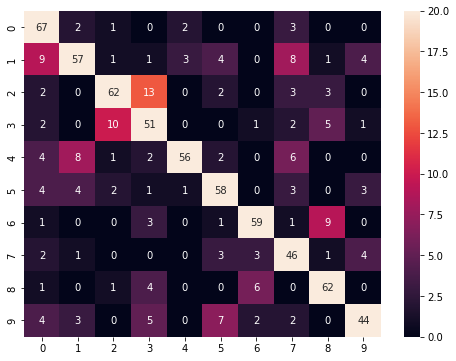

In [42]:
conf = confusion_matrix(np.argmax(Y_test, axis=1), pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, fmt="d", vmax=20)

##### TODO - figure out how to convert mel_specs back to raw audio (to better see misclassifications)

### Synthetic Speech Commands dataset conversion: ###

In [43]:
#### BATCH CONVERSION for second (slower) set ####
### TODO: figure out best values for n_fft, hop_length
n_fft = 2048 # number of samples in a window per fft
hop_length = 512 # amount of samples we are shifting after each fft
mel_spectrograms_2 = [] # list to store each converted signal

### actual conversion process
for signal in audio_signals_2:
  ms = signal_to_mel_spectrogram(signal, hop_length, n_fft)
  mel_spectrograms_2.append(ms)

In [44]:
### Final X,Y data:
# X = mel_spectrograms_2
# Y = labels_2

#print(mel_spectrograms_2[4].shape)

mel_spectrograms_2 = np.array(mel_spectrograms_2)
labels_2 = np.array(labels_2)
print(mel_spectrograms_2.shape)
print(labels_2.shape)


(13963, 1025, 44)
(13964,)


In [45]:
### shuffling the data
shuf = np.arange(mel_spectrograms_2.shape[0])
np.random.shuffle(shuf)
mel_spectrograms_2 = mel_spectrograms_2[shuf]
labels_2 = labels_2[shuf]

In [46]:
classes_2 = list(set(labels_2))

# Next, we create character->index and index->character dictionaries for the one-hot encodings.
class_indices = dict((c, i) for i, c in enumerate(classes_2))
indices_class = dict((i, c) for i, c in enumerate(classes_2))
len(classes_2)

10

In [47]:
y = np.zeros((mel_spectrograms_2.shape[0], len(classes_2)))
#y = np.zeros(8370, 30)
for i, c in enumerate(labels_2):
  y[i,class_indices[c]] = 1

In [48]:
print(y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [49]:
import random
n = random.randrange(0,mel_spectrograms_2.shape[0])
y[n]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [50]:
### creating X_train/X_test, Y_train/Y_test data splits
X_train_2, y_train_2, X_test_2, y_test_2 = split_data(mel_spectrograms_2, y)
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)

(9774, 1025, 44)
(9774, 10)
(4189, 1025, 44)
(4189, 10)



#### model

In [51]:
y_train_2[100]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [52]:
# reshaping 3D tensors to 4D tensors for fully-connected layers
X_train_2 = X_train_2.reshape(-1, 1025, 44, 1) # FIXME (batch, rows, columns, channels)
# 60000*28*28
# np.extend_dims(X_train, -1)
X_test_2 = X_test_2.reshape(-1, 1025, 44, 1) # FIXME (batch, rows, columns, channels)

# it is in int8 format, the neural network requires float32, convert the arrays to float32
X_train_2 = X_train_2.astype("float32")
X_test_2 = X_test_2.astype("float32")


### converting Y_train/Y_test from explicit digits (0,...,9) to categorical (ex. 5 -> [0,0,0,0,0,1,0,0,0,0])
nb_classes_2=len(classes_2)
'''
Y_train_2 = to_categorical(y_train_2, nb_classes_2)
Y_test_2 = to_categorical(y_test_2, nb_classes_2)
'''

'\nY_train_2 = to_categorical(y_train_2, nb_classes_2)\nY_test_2 = to_categorical(y_test_2, nb_classes_2)\n'

In [53]:
### for testing purposes
#words = np.asarray(range(nb_classes_2))
print(y_train_2[0].astype(np.int))

[0 1 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


##### defining the model

In [54]:
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model2 = Sequential()
model2.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(1025,44,1,)))
model2.add(MaxPool2D()) 
model2.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model2.add(Flatten())
model2.add(Dense(nb_classes_2, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1021, 40, 6)       156       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 510, 20, 6)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 506, 16, 16)       2416      
                                                                 
 flatten_1 (Flatten)         (None, 129536)            0         
                                                                 
 dense_1 (Dense)             (None, 10)                1295370   
                                                                 
Total params: 1,297,942
Trainable params: 1,297,942
Non-trainable params: 0
____________________________________________

In [56]:
model2.input

<KerasTensor: shape=(None, 1025, 44, 1) dtype=float32 (created by layer 'conv2d_2_input')>

##### training

In [57]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping

In [58]:
network_history = model2.fit(X_train_2, y_train_2, batch_size=128, 
                            epochs=20, verbose=1, validation_split=0.2, # seems to start overfitting at epoch 5
                            callbacks=[es])

Epoch 1/20
62/62 [==============================] - 198s 3s/step - loss: 62.8655 - accuracy: 0.6539 - val_loss: 0.6015 - val_accuracy: 0.8624
Epoch 2/20
62/62 [==============================] - 201s 3s/step - loss: 0.1980 - accuracy: 0.9431 - val_loss: 0.2009 - val_accuracy: 0.9545
Epoch 3/20
62/62 [==============================] - 196s 3s/step - loss: 0.0236 - accuracy: 0.9946 - val_loss: 0.2236 - val_accuracy: 0.9478
Epoch 4/20
62/62 [==============================] - 197s 3s/step - loss: 0.0038 - accuracy: 0.9996 - val_loss: 0.1683 - val_accuracy: 0.9673
Epoch 5/20
62/62 [==============================] - 196s 3s/step - loss: 3.1121e-04 - accuracy: 1.0000 - val_loss: 0.1589 - val_accuracy: 0.9668
Epoch 6/20
62/62 [==============================] - 196s 3s/step - loss: 1.1411e-04 - accuracy: 1.0000 - val_loss: 0.1589 - val_accuracy: 0.9688
Epoch 7/20
62/62 [==============================] - 199s 3s/step - loss: 6.9826e-05 - accuracy: 1.0000 - val_loss: 0.1602 - val_accuracy: 0.9683


#### Evaluation

In [59]:
print(model2.evaluate(X_test_2, y_test_2))

131/131 [==============================] - 33s 249ms/step - loss: 0.1378 - accuracy: 0.9723
[0.137836754322052, 0.9723083972930908]


In [60]:
preds_2=model2.predict(X_test_2)

In [61]:
preds_2.shape

(4189, 10)

In [62]:
preds_2[0], y_test_2[0]

(array([1.0000000e+00, 6.7866328e-23, 4.6159037e-28, 3.0834482e-31,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.4839119e-34, 0.0000000e+00], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [63]:
pred_labels_2=np.argmax(preds_2, axis=1)

In [64]:
pred_labels_2[0]

0

#### Evaluation cont (confusion matrix/misclassifications)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [66]:
pred_labels_2
pred_labels_2.shape

(4189,)

In [67]:
print(classification_report(np.argmax(y_test_2, axis=1), pred_labels_2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       365
           1       0.98      0.98      0.98       330
           2       0.97      0.98      0.98       441
           3       0.96      0.96      0.96       411
           4       0.99      0.99      0.99       352
           5       0.98      0.98      0.98       397
           6       0.97      0.99      0.98       703
           7       0.98      0.96      0.97       426
           8       0.96      0.92      0.94       371
           9       0.94      0.96      0.95       393

    accuracy                           0.97      4189
   macro avg       0.97      0.97      0.97      4189
weighted avg       0.97      0.97      0.97      4189



In [68]:
print( "lowest performers:\n",
    indices_class[5], "\n",
    indices_class[15], "\n",
    indices_class[21], "\n", 
    indices_class[26]
)

KeyError: ignored

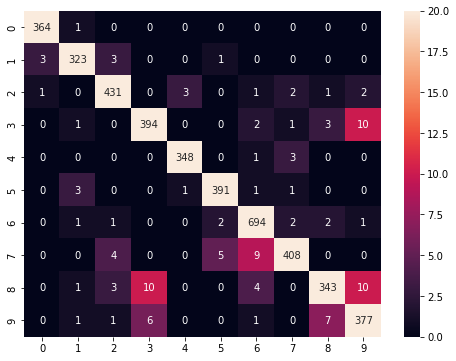

In [69]:
conf_2 = confusion_matrix(np.argmax(y_test_2, axis=1), pred_labels_2)
plt.figure(figsize=(8,6))
sns.heatmap(conf_2, annot=True, fmt="d", vmax=20)

In [ ]:
# NOTE: LOTS of confusion between classes 5 ('on') and 21 ('one') (in both directions)